In [35]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 22, 10

In [36]:
# importing datasets
dtl = pd.read_csv('D:/internships/summer_Triassic/dataset/original/csvfiles/SalesDTL.csv', header = 0, 
                usecols = ['SHDR_IDL', 'RECEIPTNO', 'PROD_IDL', 'PRTYPE_IDL', 'DEPT_IDL', 'RPRICE', 'CPRICE', 'QUANTITY', 
                           'DATEORDER','EMPORDERED', 'DISPORDER', 'PRODGROUP', 'SEAT', 'TYPE', 'TRACKSTOCK', 
                           'PCHANNELS', 'MASTERITEM', 'ISVOIDED',  'COURSESORT', 'OMSDTL_IDL' ]
               , parse_dates= ['DATEORDER'])
hdr = pd.read_csv('D:/internships/summer_Triassic/dataset/original/csvfiles/SalesHDR.csv', header=0, 
                  usecols = ['HEADERTYPE', 'BUSDATE', 'TABLENUM', 'NUMCUST' ,'MDSETOTAL','EOPEN_IDL', 'ECLOSE_IDL', 'DATESEATED',
                             'DATEOPEN', 'DATECLOSED','CUST_IDL', 'STYPE_IDL', 'STAT_IDL' ,'RCPTPRNTED','GRATUITY',
                                  'PRICELEVEL', 'SEATCOUNT'], 
                parse_dates= ['BUSDATE','DATESEATED', 'DATEOPEN', 'DATECLOSED'] )

In [37]:
# Renaming the column
dtl_new = dtl.rename(columns = {'DATEORDER':'DATE'})

In [38]:
dtl_new['total_price'] = dtl_new['RPRICE']*dtl_new['QUANTITY']
dtl_new.set_index('DATE',inplace=True) # setting DATE as index.

dtl_new = dtl_new.loc['2016-03-06':]  # Taking continuous data from 2016-03-06 onwards.
dtl_new_sampled = dtl_new.resample('D').sum() # Sampling with respect to day(D).


In [39]:
# Performing the same operations on 'hdr' data as we did on 'dtl'.
hdr_new = hdr.rename(columns = {'DATESEATED':'DATE'})

In [40]:
hdr_new.set_index('DATE',inplace=True)

hdr_new = hdr_new.loc['2016-03-06':]
hdr_new_sampled = hdr_new.resample('D').sum()
#hdr_new_sampled['MDSETOTAL'].plot()

In [41]:
# concatenating two datasets.
cmb = pd.concat([hdr_new_sampled, dtl_new_sampled], axis =1)

In [42]:
# Taking only needed attributes for analysis.
cmb_final = cmb[['NUMCUST','MDSETOTAL','total_price']]
cmb_final.head(5)

,NUMCUST,MDSETOTAL,total_price
DATE,,,
2016-03-06,434,5323.03,9566.61
2016-03-07,299,3572.69,5212.72
2016-03-08,261,3334.21,4879.61
2016-03-09,219,2450.07,3282.25
2016-03-10,233,2786.05,3725.68


In [10]:
## For the tiem being, we are considering NUMCUST column only for time-series analysis

In [43]:
cmb_numcust = cmb_final['NUMCUST']
print(cmb_numcust.head(5))

DATE
2016-03-06    434
2016-03-07    299
2016-03-08    261
2016-03-09    219
2016-03-10    233
Freq: D, Name: NUMCUST, dtype: int64


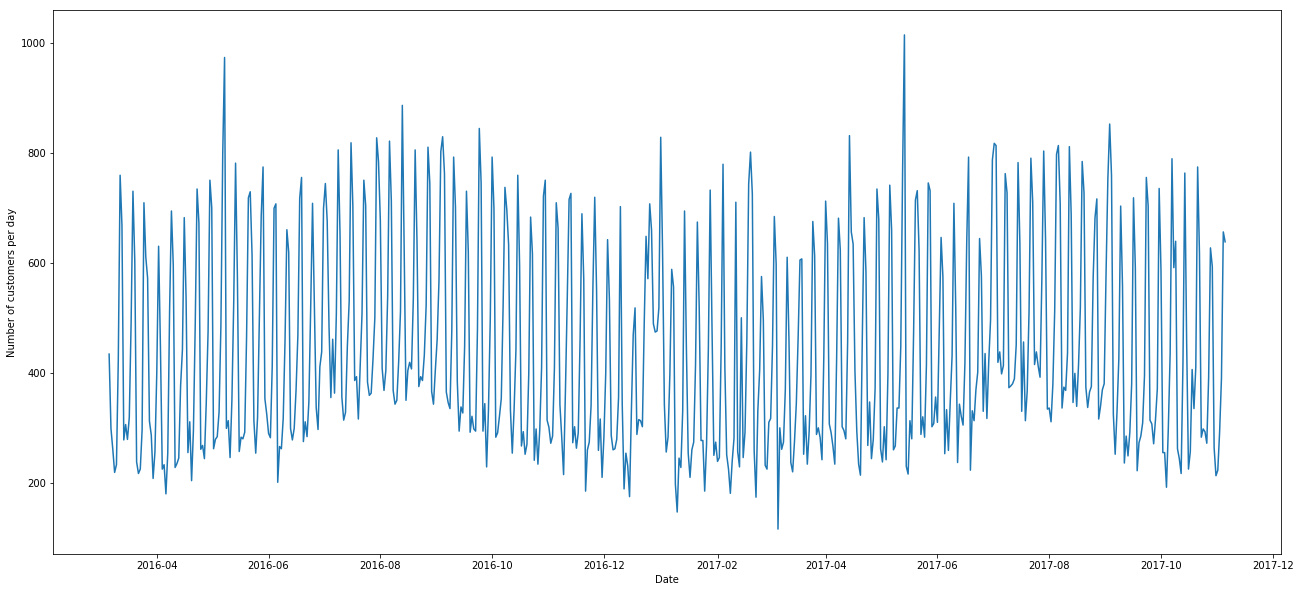

In [44]:
## plotting the graph
plt.xlabel('Date')
plt.ylabel('Number of customers per day')
plt.plot(cmb_numcust)

In [13]:
# From the graph it is evident that the data is non-stationary and has seasonal variation.
# For checking the extent of stationarity, we require to test the (i)rolling statistics (eg:moving average) and (ii)Dickey-Fuller test.

In [ ]:
# There are 2 reasons behind non-stationarity of time series
    # Trend: varying mean over time. We need constant mean for stationary of time series.
    # Seasonality: variations at specific time. We need constant variations for stationary of time series.
# First solve trend(constant mean) problem
# Most popular method is moving average.
# Moving average: We have window that take the average over the past 'n' sample. 'n' is window size.

In [56]:
## (i)Finding rolling statistics.
## window =7 ; rolling mean at weekly level.

rolmean = cmb_numcust.rolling(window='7D').mean() 
rolmean2 = cmb_numcust.rolling(window='30D').mean()
rolstd = cmb_numcust.rolling(window='7D').std()
rolstd2 = cmb_numcust.rolling(window='30D').std()
print(rolmean.head(5),rolmean2.head(5),rolstd.head(5), rolstd2.head(5))

DATE
2016-03-06    434.000000
2016-03-07    366.500000
2016-03-08    331.333333
2016-03-09    303.250000
2016-03-10    289.200000
Freq: D, Name: NUMCUST, dtype: float64 DATE
2016-03-06    434.000000
2016-03-07    366.500000
2016-03-08    331.333333
2016-03-09    303.250000
2016-03-10    289.200000
Freq: D, Name: NUMCUST, dtype: float64 DATE
2016-03-06          NaN
2016-03-07    95.459415
2016-03-08    90.919378
2016-03-09    93.089115
2016-03-10    86.522829
Freq: D, Name: NUMCUST, dtype: float64 DATE
2016-03-06          NaN
2016-03-07    95.459415
2016-03-08    90.919378
2016-03-09    93.089115
2016-03-10    86.522829
Freq: D, Name: NUMCUST, dtype: float64


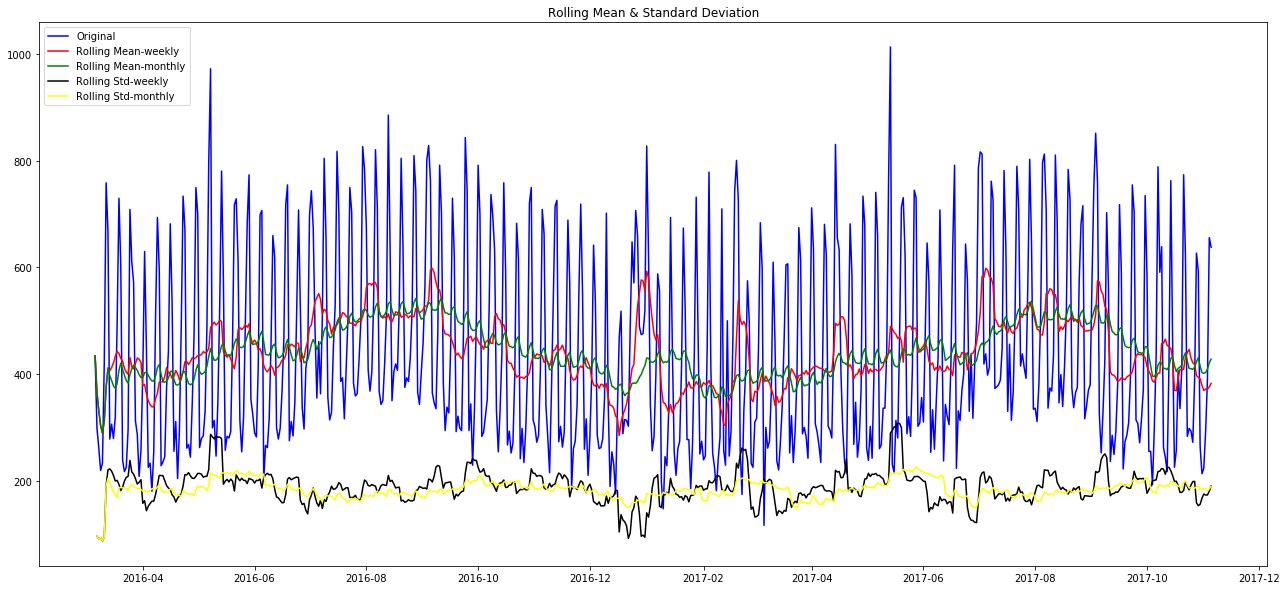

In [57]:
#Plot rolling statistics
orig = plt.plot(cmb_numcust, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean-weekly')
mean2 = plt.plot(rolmean2, color ='green', label = 'Rolling Mean-monthly') 
std = plt.plot(rolstd, color='black', label='Rolling Std-weekly')
std2 =plt.plot(rolstd2, color = 'yellow', label= 'Rolling Std-monthly')
plt.legend(loc=2)
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
# At first instance let's take weekly rolling statistics.
# But the rolling mean(red line) is not that constant in the graph.-- not stationary.
# The rolling standard deviation (black line) is almost constant. -- let's assume it is stationary.
# Now let's implement Dickey-Fuller Test to know more about stationarity.

In [58]:
## Performing Augmented Dickey-Fuller Test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(cmb_numcust, autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  -3.509137
p-value                          0.007756
#Lags Used                      13.000000
Number of Observations Used    596.000000
Critical Value (1%)             -3.441370
Critical Value (5%)             -2.866402
Critical Value (10%)            -2.569359
dtype: float64


In [ ]:
## For a Time series to be stationary, its ADCF test should have:
        # 1. p-value to be low (according to the null hypothesis)
        # 2. The critical values at 1%,5%,10% confidence intervals should be greater than the Test Statistics
        
## Hence, we can say that our series is stationary.

In [ ]:
## Now again we need to make the data much more stationary. So we can go to log scale transformation.
## Before that we are creating a function for rolling statistics and Dickey-Fuller test.
## creating a function for checking all the parameters for time series stationarity.

In [59]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=7).mean()
    movingSTD = timeseries.rolling(window=7).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Text(0.5,1,'Log scale transformation of cmb_numcust')

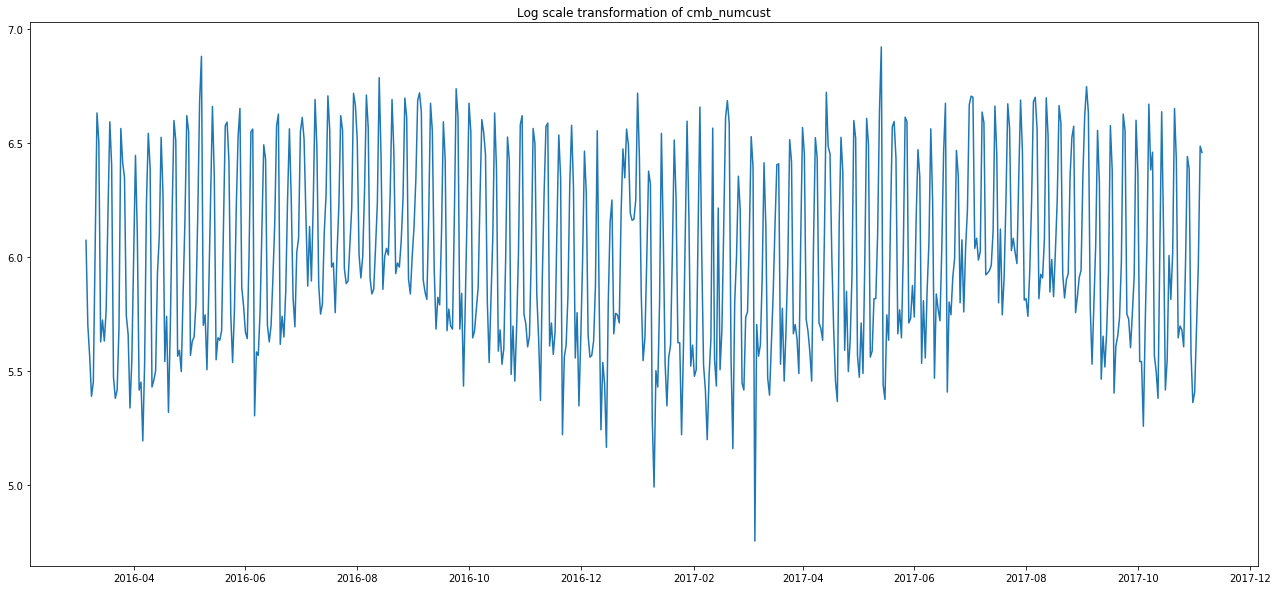

In [69]:
# Estimating trend.
cmb_numcust_logscale = np.log(cmb_numcust)
plt.plot(cmb_numcust_logscale)
plt.title('Log scale transformation of cmb_numcust')

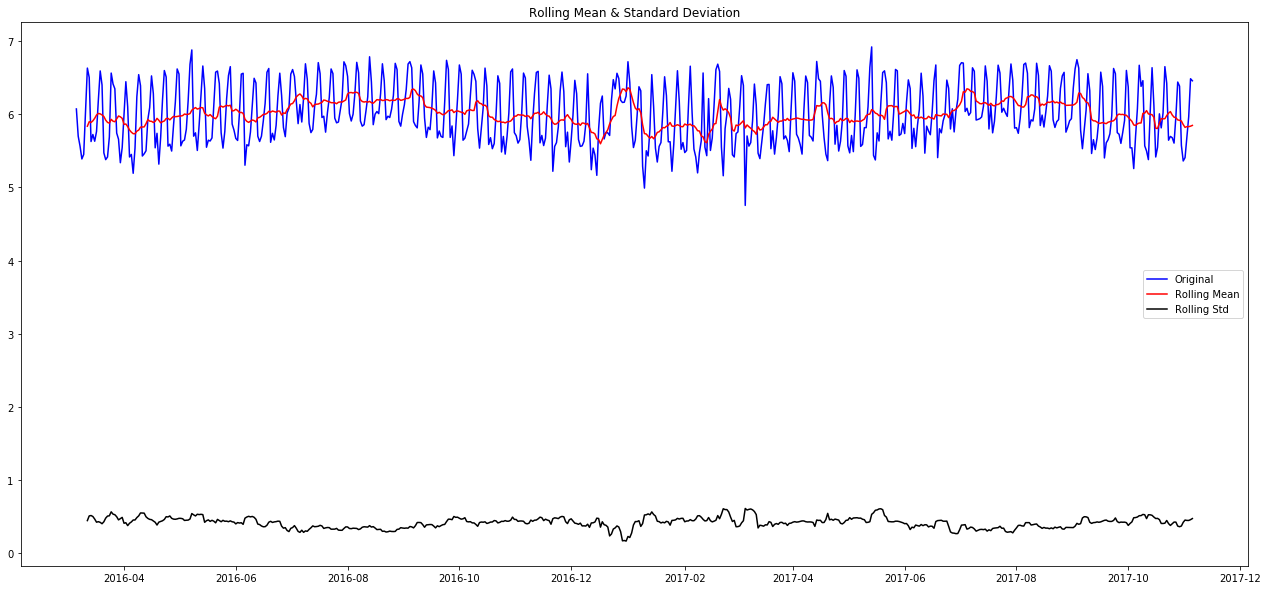

Results of Dickey Fuller Test:
Test Statistic                  -3.432842
p-value                          0.009889
#Lags Used                      13.000000
Number of Observations Used    596.000000
Critical Value (1%)             -3.441370
Critical Value (5%)             -2.866402
Critical Value (10%)            -2.569359
dtype: float64


In [70]:
## log scale transformation (for making stationary) and analysis
test_stationarity(cmb_numcust_logscale)

In [ ]:
# The plots after log transformation has become more appealing in favour for stationarity. 
# And the Dickey-Fuller test confirms it wrt that of without transformation (although the p-value has been increased slightly, Test Statistic has came down.).

In [ ]:
# Another method to avoid trend and seasonality is given below.
   # Differencing method: i.e taking difference between time series and shifted time series in log scale. 

Text(0.5,1,'Time shift transformation of cmb_numcust_logscale')

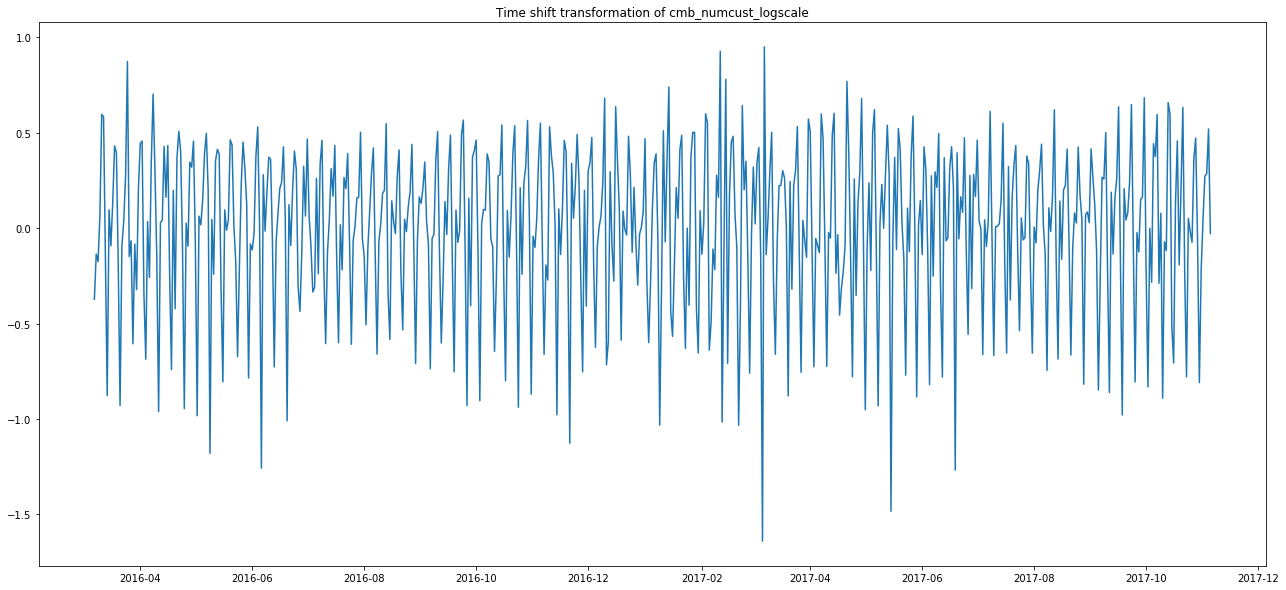

In [71]:
## Time shift transformation
cmb_numcustLogDiffShifting = cmb_numcust_logscale - cmb_numcust_logscale.shift()
plt.plot(cmb_numcustLogDiffShifting)
plt.title('Time shift transformation of cmb_numcust_logscale')

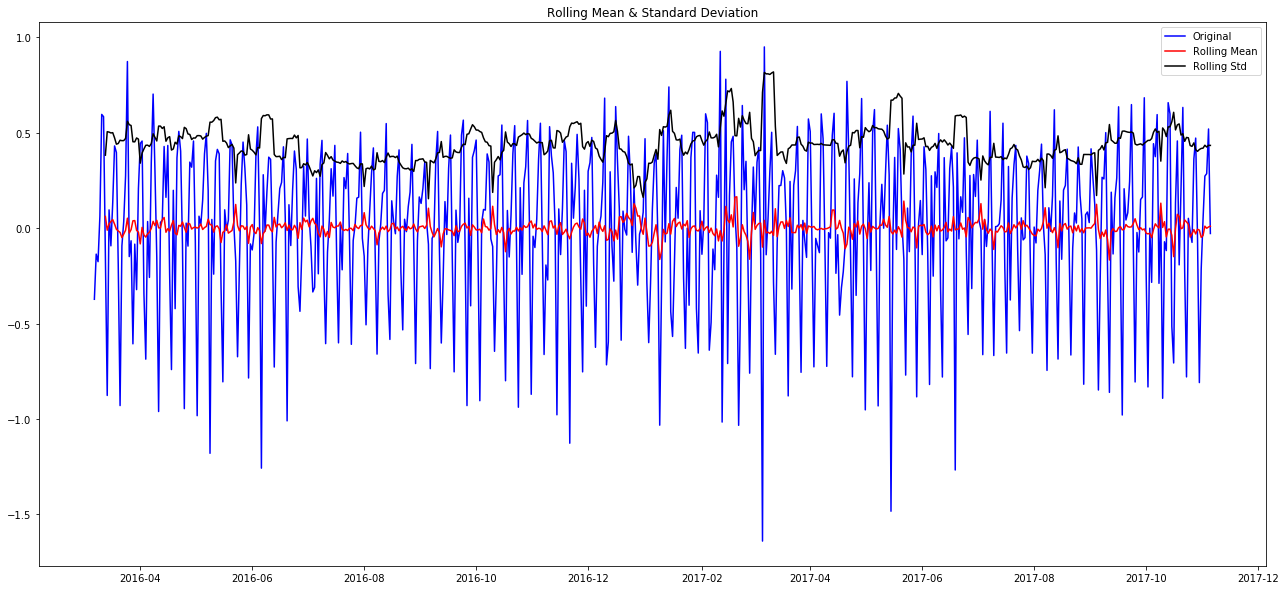

Results of Dickey Fuller Test:
Test Statistic                -9.574047e+00
p-value                        2.248102e-16
#Lags Used                     1.900000e+01
Number of Observations Used    5.890000e+02
Critical Value (1%)           -3.441501e+00
Critical Value (5%)           -2.866460e+00
Critical Value (10%)          -2.569390e+00
dtype: float64


In [72]:
cmb_numcustLogDiffShifting.dropna(inplace=True) # some values in difference will be NA.We need to drop them.
test_stationarity(cmb_numcustLogDiffShifting)

In [ ]:
# Now tremendously the p-value has been reduced almost to zero, indicates plausible condition for stationarity.

In [50]:
## ARIMA modelling 
## on cmb_numcust_logscale

Text(0.5,1,'RSS: -104.6811')

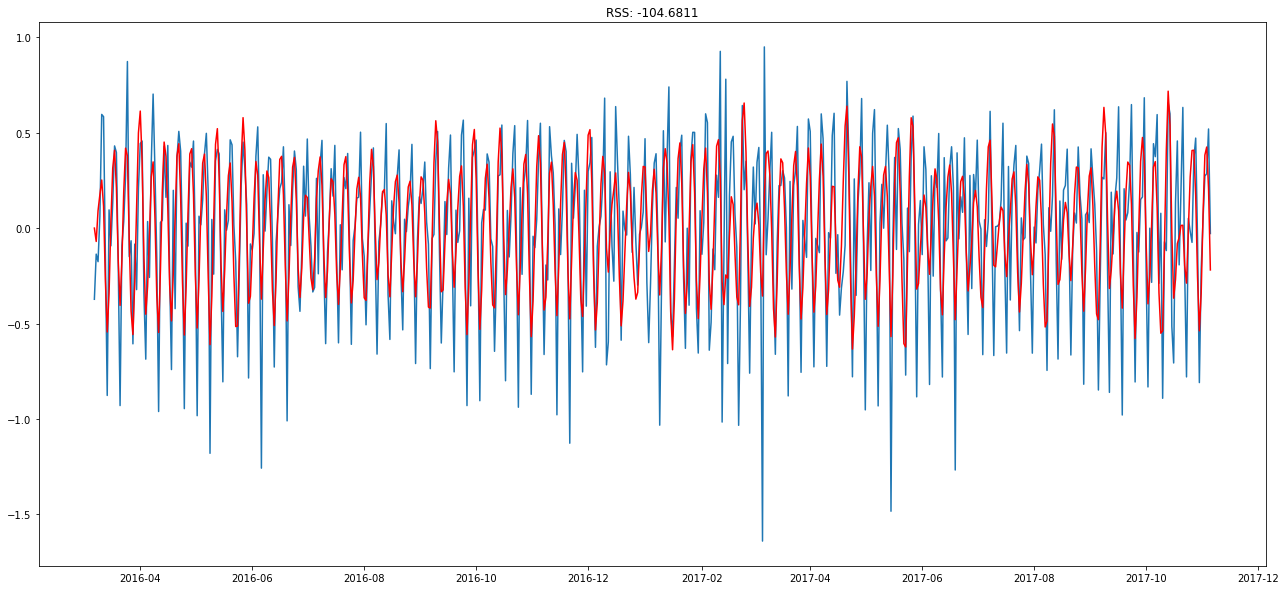

In [92]:
model = ARIMA(cmb_numcust_logscale, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(cmb_numcustLogDiffShifting)

plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - cmb_numcustLogDiffShifting**2)))

#plt.plot(cmb_numcust_logscale, color='blue')


In [93]:
## With the ARIMA model built, we will now generate predictions. 
#  But, before we do any plots for predictions ,we need to reconvert the predictions back to original form. 
# This is because, our model was built on log transformed data.

In [94]:
## Predictions and reverse transformations.

In [95]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

DATE
2016-03-07    0.000464
2016-03-08   -0.069478
2016-03-09    0.091789
2016-03-10    0.176376
2016-03-11    0.252466
Freq: D, dtype: float64


In [96]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head(5))

DATE
2016-03-07    0.000464
2016-03-08   -0.069014
2016-03-09    0.022774
2016-03-10    0.199150
2016-03-11    0.451616
Freq: D, dtype: float64


In [97]:
predictions_ARIMA_log = pd.Series(cmb_numcust_logscale.iloc[0], index=cmb_numcust_logscale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

DATE
2016-03-06    6.073045
2016-03-07    6.073508
2016-03-08    6.004030
2016-03-09    6.095819
2016-03-10    6.272195
Freq: D, dtype: float64

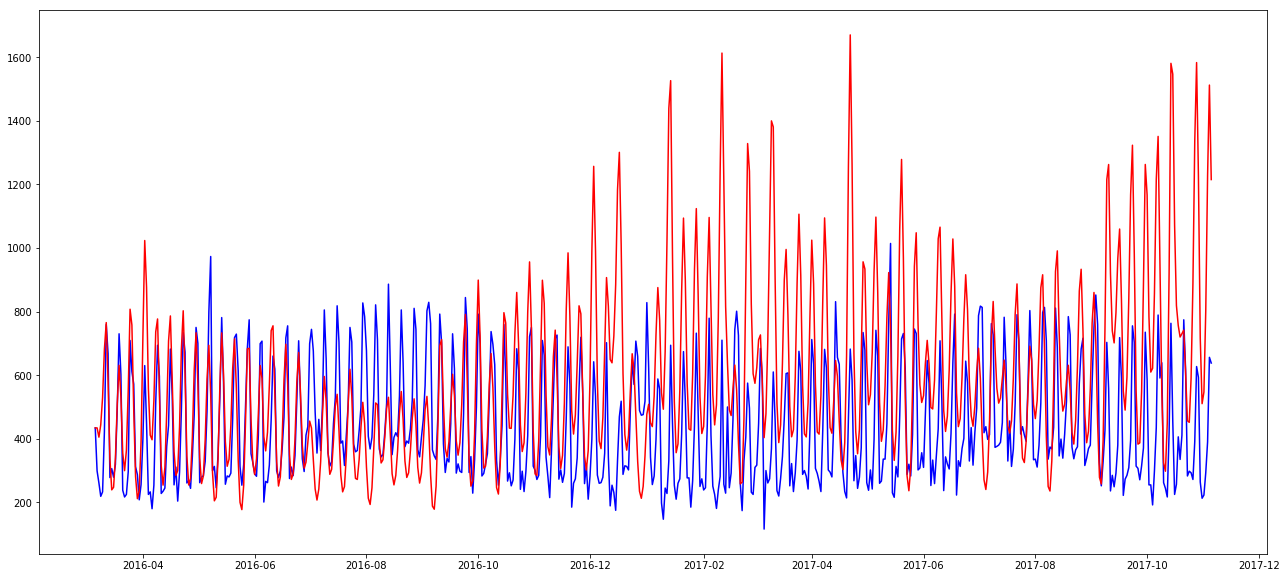

In [98]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(cmb_numcust, color ='blue')
plt.plot(predictions_ARIMA, color ='red')

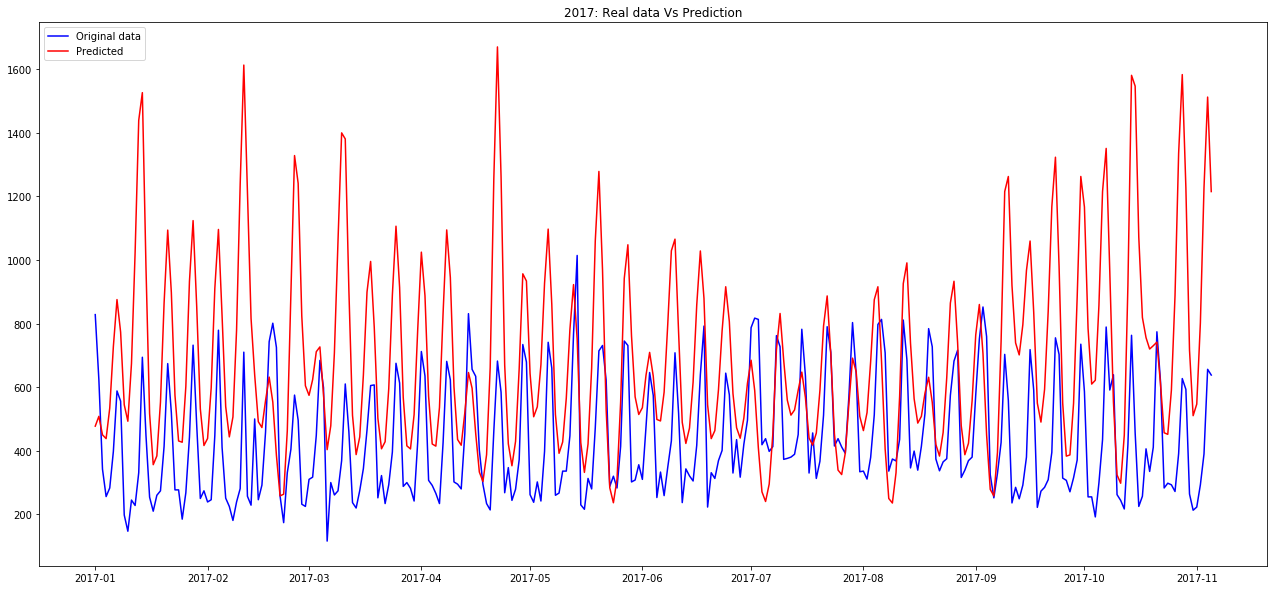

In [106]:
# Plot for the year 2017.
# Real Vs predicted.

plt.title('2017: Real data Vs Prediction')
plt.plot(cmb_numcust['2017-01-01':], color ='blue', label = 'Original data')
plt.plot(predictions_ARIMA['2017-01-01':], color ='red', label = 'Predicted')
plt.legend(loc =2)